In [10]:
import ehrapy as ep
import pandas as pd
import numpy as np
import scanpy as sc
import patpy

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP

from sampleclr.contrastive_model import ContrastiveModel
from sampleclr.utils import get_sample_representations
from sampleclr.utils import plot_losses

In [11]:
DATA_PATH = "../data/COMBAT_Stephenson_harmonized.h5ad" 
METADATA_PATH = "../data/COMBAT_Stephenson_harmonized_metadata.csv"
sample_id_col = "donor_id" 

In [12]:
adata = sc.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 1399435 × 1856
    obs: 'Site', 'SARSCoV2PCR', 'Outcome', 'TimeSinceOnset', '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'split', 'cell_coarse_aligned', 'Status', 'severity_ord', 'severity_idx', 'outcome_bin', 'dataset', 'sample_id', 'Status_encoded'
    obsm: 'X_pca', 'X_scANVI_batch', 'X_scANVI_sample', 'X_scVI_batch', 'X_scVI_sample', 'X_scpoli', 'X_umap'
    layers: 'X_raw_counts'

In [13]:
metadata = pd.read_csv(METADATA_PATH, index_col=0)
metadata

,dataset,Site,Status,severity_ord,outcome_bin,SARSCoV2PCR,TimeSinceOnset,split,Status_pred
S00109-Ja001E-PBCa,combat,Oxford,Covid,severe,0.0,1,12.0,val,Covid
S00112-Ja003E-PBCa,combat,Oxford,Covid,mild,0.0,1,12.0,val,Covid
S00005-Ja005E-PBCa,combat,Oxford,Covid,critical,0.0,1,14.0,val,Covid
S00061-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,6.0,val,Covid
S00056-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,23.0,val,Covid
...,...,...,...,...,...,...,...,...,...
BGCV13_CV0171,stephenson,Cambridge,Covid,mild,0.0,1,15.0,test,Covid
BGCV14_CV0137,stephenson,Cambridge,Covid,moderate,0.0,1,12.0,test,Covid
BGCV14_CV0284,stephenson,Cambridge,Covid,NaN,NaN,1,10.0,test,Covid
BGCV14_CV0940,stephenson,Cambridge,Healthy,healthy,0.0,0,NaN,test,Healthy


In [14]:
metadata[["Site", "dataset"]].value_counts()

Site        dataset   
Oxford      combat        124
Ncl         stephenson     55
Cambridge   stephenson     51
Sanger      stephenson     11
St_Georges  combat         10
Name: count, dtype: int64

In [15]:
metadata["split"] = "train"
metadata.loc[metadata["dataset"] == "combat", "split"] = "test"
metadata.loc[metadata["Site"] == "Sanger", "split"] = "val"

In [16]:
metadata["severity_ord"].unique()

array(['severe', 'mild', 'critical', nan, 'healthy', 'moderate'],
      dtype=object)

Make sure validation set has all the severities

In [17]:
additional_val_samples = metadata[metadata["dataset"] == "stephenson"].groupby("severity_ord").head(2).index
metadata.loc[additional_val_samples, "split"] = "val"

In [18]:
metadata["split"].value_counts()

split
test     134
train     96
val       21
Name: count, dtype: int64

In [19]:
pd.crosstab(metadata["Status"], metadata["split"])

split,test,train,val
Status,,,
Covid,79,75,19
Flu,8,0,0
Healthy,22,21,2
Sepsis,25,0,0


In [20]:
pd.crosstab(metadata["severity_ord"], metadata["split"])

split,test,train,val
severity_ord,,,
critical,18,6,2
healthy,22,21,2
mild,18,26,2
moderate,0,26,2
severe,41,5,2


In [21]:
metadata["severity_num"] = metadata["severity_ord"].map({
    "healthy": 0,
    "mild": 1,
    "moderate": 2,
    "severe": 3,
    "critical": 4,
})

In [22]:
meta_adata = ep.io.df_to_anndata(metadata, columns_obs_only=metadata.columns.tolist())
meta_adata

AnnData object with n_obs × n_vars = 251 × 0
    obs: 'dataset', 'Site', 'Status', 'severity_ord', 'outcome_bin', 'SARSCoV2PCR', 'TimeSinceOnset', 'split', 'Status_pred', 'severity_num'
    layers: 'original'

In [23]:
cell_counts = adata.obs["sample_id"].value_counts()
meta_adata.obs["n_cells"] = meta_adata.obs.index.map(cell_counts)

<Axes: xlabel='n_cells', ylabel='Density'>

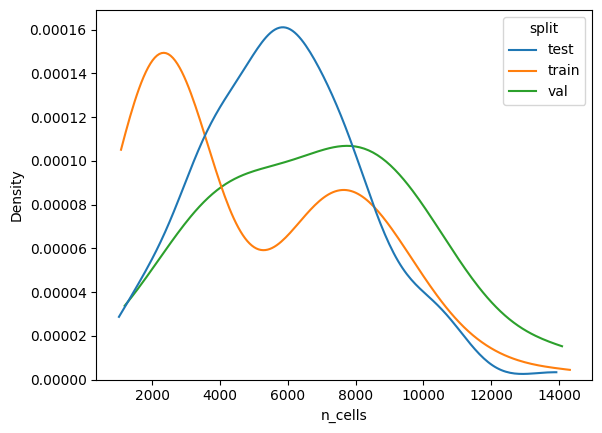

In [24]:
sns.kdeplot(meta_adata.obs, x="n_cells", hue="split", common_norm=False, cut=0)

In [25]:
train_ids = meta_adata[meta_adata.obs["split"] == "train"].obs_names
val_ids = meta_adata[meta_adata.obs["split"] == "val"].obs_names

print(len(train_ids), len(val_ids), round(len(val_ids) / (len(train_ids) + len(val_ids)), 2))

96 21 0.18


In [26]:
adata

AnnData object with n_obs × n_vars = 1399435 × 1856
    obs: 'Site', 'SARSCoV2PCR', 'Outcome', 'TimeSinceOnset', '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'split', 'cell_coarse_aligned', 'Status', 'severity_ord', 'severity_idx', 'outcome_bin', 'dataset', 'sample_id', 'Status_encoded'
    obsm: 'X_pca', 'X_scANVI_batch', 'X_scANVI_sample', 'X_scVI_batch', 'X_scVI_sample', 'X_scpoli', 'X_umap'
    layers: 'X_raw_counts'

In [27]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [28]:
meta_adata.obs

,dataset,Site,Status,severity_ord,outcome_bin,SARSCoV2PCR,TimeSinceOnset,split,Status_pred,severity_num,n_cells
S00109-Ja001E-PBCa,combat,Oxford,Covid,severe,0.0,1,12.0,test,Covid,3.0,3984
S00112-Ja003E-PBCa,combat,Oxford,Covid,mild,0.0,1,12.0,test,Covid,1.0,7384
S00005-Ja005E-PBCa,combat,Oxford,Covid,critical,0.0,1,14.0,test,Covid,4.0,9002
S00061-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,6.0,test,Covid,3.0,4278
S00056-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,23.0,test,Covid,3.0,7600
...,...,...,...,...,...,...,...,...,...,...,...
BGCV13_CV0171,stephenson,Cambridge,Covid,mild,0.0,1,15.0,train,Covid,1.0,2218
BGCV14_CV0137,stephenson,Cambridge,Covid,moderate,0.0,1,12.0,train,Covid,2.0,3875
BGCV14_CV0284,stephenson,Cambridge,Covid,NaN,NaN,1,10.0,train,Covid,NaN,3177
BGCV14_CV0940,stephenson,Cambridge,Healthy,healthy,0.0,0,NaN,train,Healthy,0.0,2958


Model: SampleCLR_Unsupervised
Best validation loss: 0.0047139739617705345


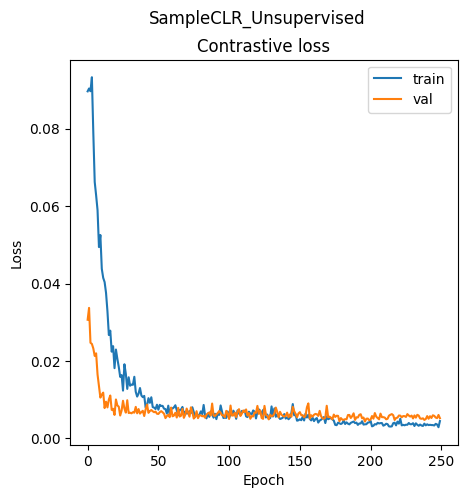

Getting representations


In [ ]:
dataset_config = {
    "layer": "X_pca",
    "batch_size": 32,
    "n_cells_per_sample": [500, 1000],
    # "trajectory_variable": "severity_num",
    # "inverse_trajectory": False,
    # "root_sample": "MH8919179"
}

model_config = {
    "num_layers": 4,
    "hidden_size": 32,
    "learning_rate_feature": 3e-4,
    "learning_rate_discriminator": 3e-5,
    "weight_decay": 1e-5,
    "n_aggregator_heads": 4,
    "aggregator_num_layers": 2,
    "aggregator_hidden_size": 32,
    "aggregator_activation": "relu",
    "output_dim": 64,
    "classifier_num_layers": 2,
    "classifier_hidden_size": 32,
    # "regression_num_layers": 2,
    # "regression_hidden_size": 64,
    # "ordinal_num_layers": 2,
    # "ordinal_hidden_size": 64,
    "discriminator_hidden_size": 16,
    "use_normalization": False,
    "feature_normalization": "BatchNorm",
    "aggregator_normalization": "LayerNorm",
    "contrastive_loss": "XSampleCLR",
    "contrastive_loss_temperature": 0.1,
    "xsample_clr_graph_temperature": 0.2,
    "num_warmup_epochs_stage1": 20,
    "num_warmup_epochs_stage2": 2,
    "verbose": False,
    "early_stopping_patience": 150,
    "lambda_": 1e-1,  # Controls weight update rate for discriminator
}

unsupervised_model_tasks = {}
batch_corrected_model_tasks = {"batch_correction": "Site"}
supervised_model_tasks = {
    "classification": ["Status"],
}
supervised_batch_corrected_model_tasks = {
    "classification": ["Status"],
    "batch_correction": "Site"
}

model_names = ["SampleCLR_Unsupervised", "SampleCLR_batch_corrected", "SampleCLR_supervised", "SampleCLR_supervised_batch_corrected"]

# Select cells for representation
subset_size = dataset_config["n_cells_per_sample"]
if isinstance(subset_size, list):
    subset_size = subset_size[1]

top_cells = (adata.obs
            .groupby("sample_id")
            .head(subset_size)
            .index)
selected_cells = adata[top_cells, :]

representation_dfs = []

for model_name, tasks in zip(
    model_names,
    [unsupervised_model_tasks, batch_corrected_model_tasks, supervised_model_tasks, supervised_batch_corrected_model_tasks]):

    model = ContrastiveModel(
        adata=adata,
        sample_key="sample_id",
        tasks=tasks,
        **dataset_config,
        train_ids=train_ids,
        val_ids=val_ids,
        use_gumbel=False,
        diversity_loss_weight=0.0,
        **model_config
    )

    best_state, best_val_loss, num_epochs_stage1_trained, num_epochs_stage2_trained = model.train(
        num_epochs_stage1=150,
        num_epochs_stage2=100,
        two_stages=True,
        stage_2="joint",
        verbose=False,
        stage1_val_metric="loss",
        stage2_val_metric="total"
    )

    print("Model:", model_name)
    print("Best validation loss:", best_val_loss)
    fig = plot_losses(model)
    fig.suptitle(model_name)
    plt.show()

    print("Getting representations")
    all_representations = np.zeros(shape=(meta_adata.n_obs, model.output_dim))
    with torch.no_grad():
        model.projector.eval()
        model.aggregator.eval()
        model.aggregator.return_weights = False
        
        for i, sample in enumerate(meta_adata.obs_names):
            sample_mask = selected_cells.obs["sample_id"] == sample
            sample_cells = torch.Tensor(selected_cells[sample_mask].obsm[dataset_config["layer"]]).unsqueeze(0).to(device)
            aggregated_cells = model.aggregator(sample_cells)
            representations = model.projector(aggregated_cells)
            all_representations[i] = representations.squeeze(0).cpu().numpy()

    representation_df = pd.DataFrame(all_representations, index=meta_adata.obs_names)

    representation_dfs.append(representation_df)

In [ ]:
umap_dfs = []
for model_name, representation_df in zip(model_names, representation_dfs):
    umap = UMAP(n_components=2, random_state=42)
    umap_dfs.append(umap.fit_transform(representation_df))

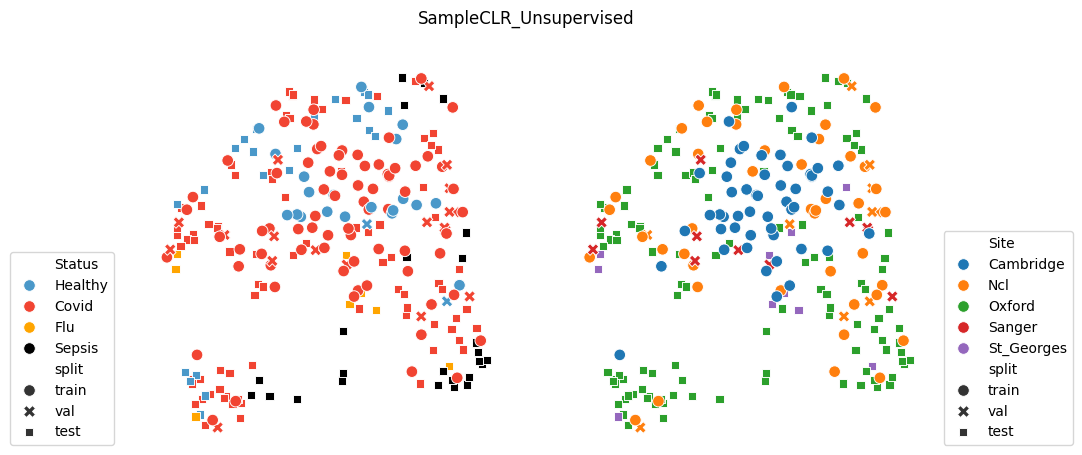

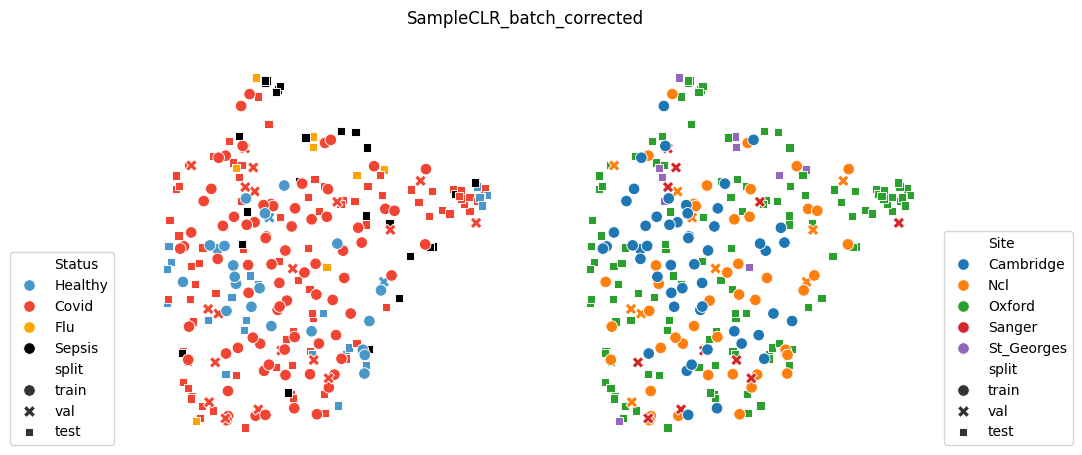

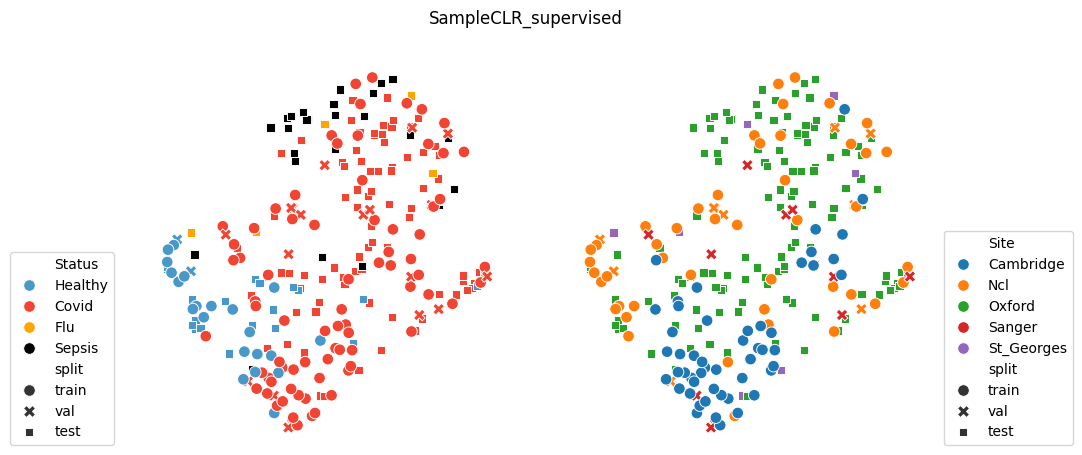

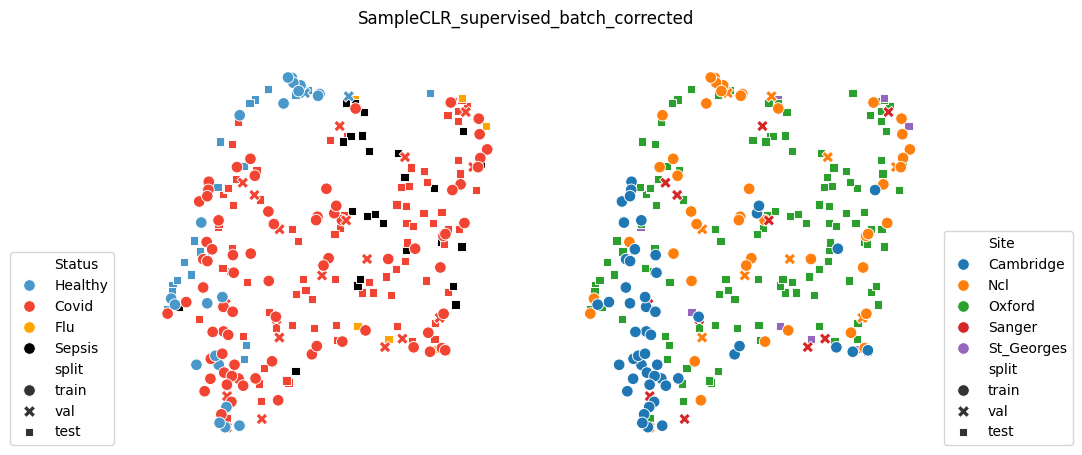

In [ ]:
for model_name, umap_df in zip(model_names, umap_dfs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
    common_kwargs = {
        "x": umap_df[:, 0],
        "y": umap_df[:, 1],
        "style_order": ["train", "val", "test"],
        "style": meta_adata.obs.loc[representation_df.index, "split"],
        "s": 70,
    }
    sns.scatterplot(
        hue=meta_adata.obs.loc[representation_df.index, "Status"],
        ax=axes[0],
        hue_order=["Healthy", "Covid", "Flu", "Sepsis"],
        palette=[plt.get_cmap("Blues")(0.6), plt.get_cmap("Reds")(0.6), "orange", "black"],
        **common_kwargs
    )
    axes[0].legend(loc=(-0.4, 0))

    sns.scatterplot(
        hue=meta_adata.obs.loc[representation_df.index, "Site"],
        ax=axes[1],
        **common_kwargs
    )
    axes[1].legend(loc=(1.05, 0))

    for ax in axes:
        # Remove frame and ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(model_name)

    plt.show()

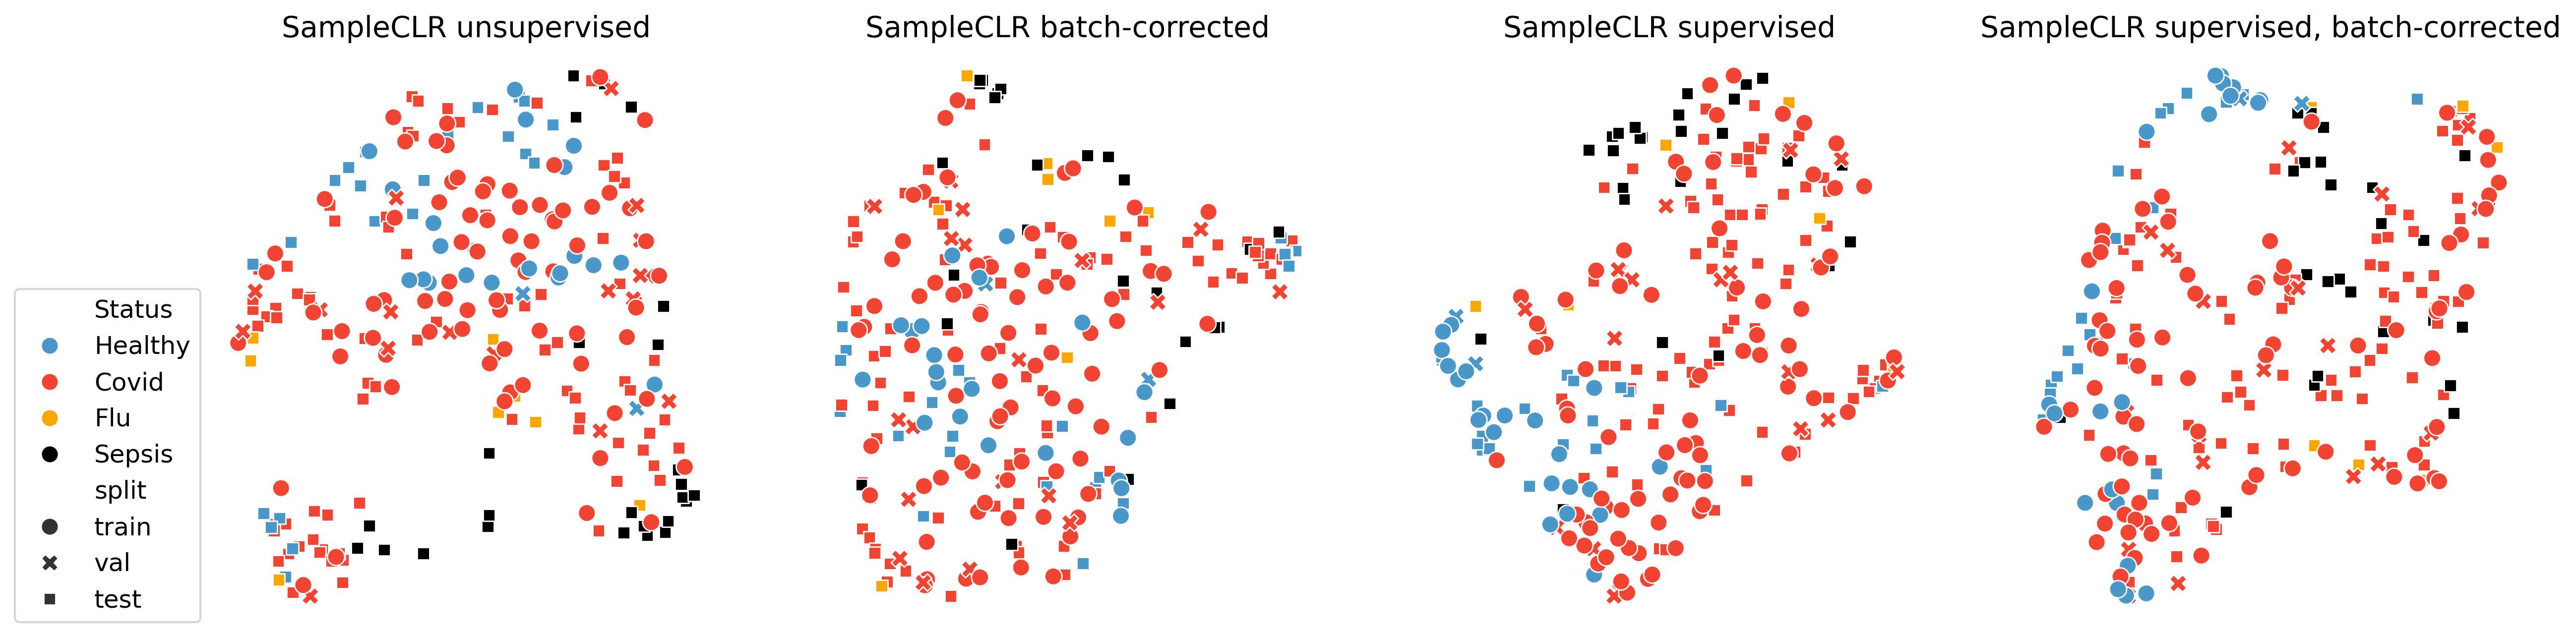

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), dpi=300)
readable_names = [
    "SampleCLR unsupervised",
    "SampleCLR batch-corrected",
    "SampleCLR supervised",
    "SampleCLR supervised, batch-corrected",
]

for i, (model_name, umap_df) in enumerate(zip(readable_names, umap_dfs)):
    common_kwargs = {
        "x": umap_df[:, 0],
        "y": umap_df[:, 1],
        "style_order": ["train", "val", "test"],
        "style": meta_adata.obs.loc[representation_df.index, "split"],
        "s": 70,
    }

    sns.scatterplot(
        hue=meta_adata.obs.loc[representation_df.index, "Status"],
        ax=axes[i],
        hue_order=["Healthy", "Covid", "Flu", "Sepsis"],
        palette=[plt.get_cmap("Blues")(0.6), plt.get_cmap("Reds")(0.6), "orange", "black"],
        legend=i==0,
        **common_kwargs
    )
    axes[i].set_title(model_name, fontsize=14)
    # Remove frame and ticks
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[0].legend(loc=(-0.4, 0), fontsize=12)


In [ ]:
meta_adata.uns["sample_representations"] = []

In [ ]:
from scipy.spatial.distance import pdist, squareform

for representation_df, representation_name in zip(representation_dfs, model_names):
    distances = pdist(representation_df, metric="cosine")
    distance_matrix = squareform(distances)
    meta_adata.obsm[f"{representation_name}_distances"] = distance_matrix
    meta_adata.uns["sample_representations"].append(representation_name)

In [ ]:
model.aggregator.return_weights = True

In [ ]:
with torch.no_grad():
    _, cell_weights = model.aggregator(torch.Tensor(adata.obsm[dataset_config["layer"]]).unsqueeze(0))
    cell_weights = cell_weights.squeeze(0).detach().numpy()

In [ ]:
cell_weights.shape

(1399435, 4)

In [ ]:
adata.obsm["X_cell_weights"] = cell_weights

for i in range(cell_weights.shape[1]):
    adata.obs[f"cell_weight_{i}"] = cell_weights[:, i]


In [ ]:
adata.obs.columns

Index(['Site', 'SARSCoV2PCR', 'Outcome', 'TimeSinceOnset', '_scvi_batch',
       '_scvi_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'split',
       'cell_coarse_aligned', 'Status', 'severity_ord', 'severity_idx',
       'outcome_bin', 'dataset', 'sample_id', 'Status_encoded', 'Site_encoded',
       'cell_weight_0', 'cell_weight_1', 'cell_weight_2', 'cell_weight_3'],
      dtype='object')

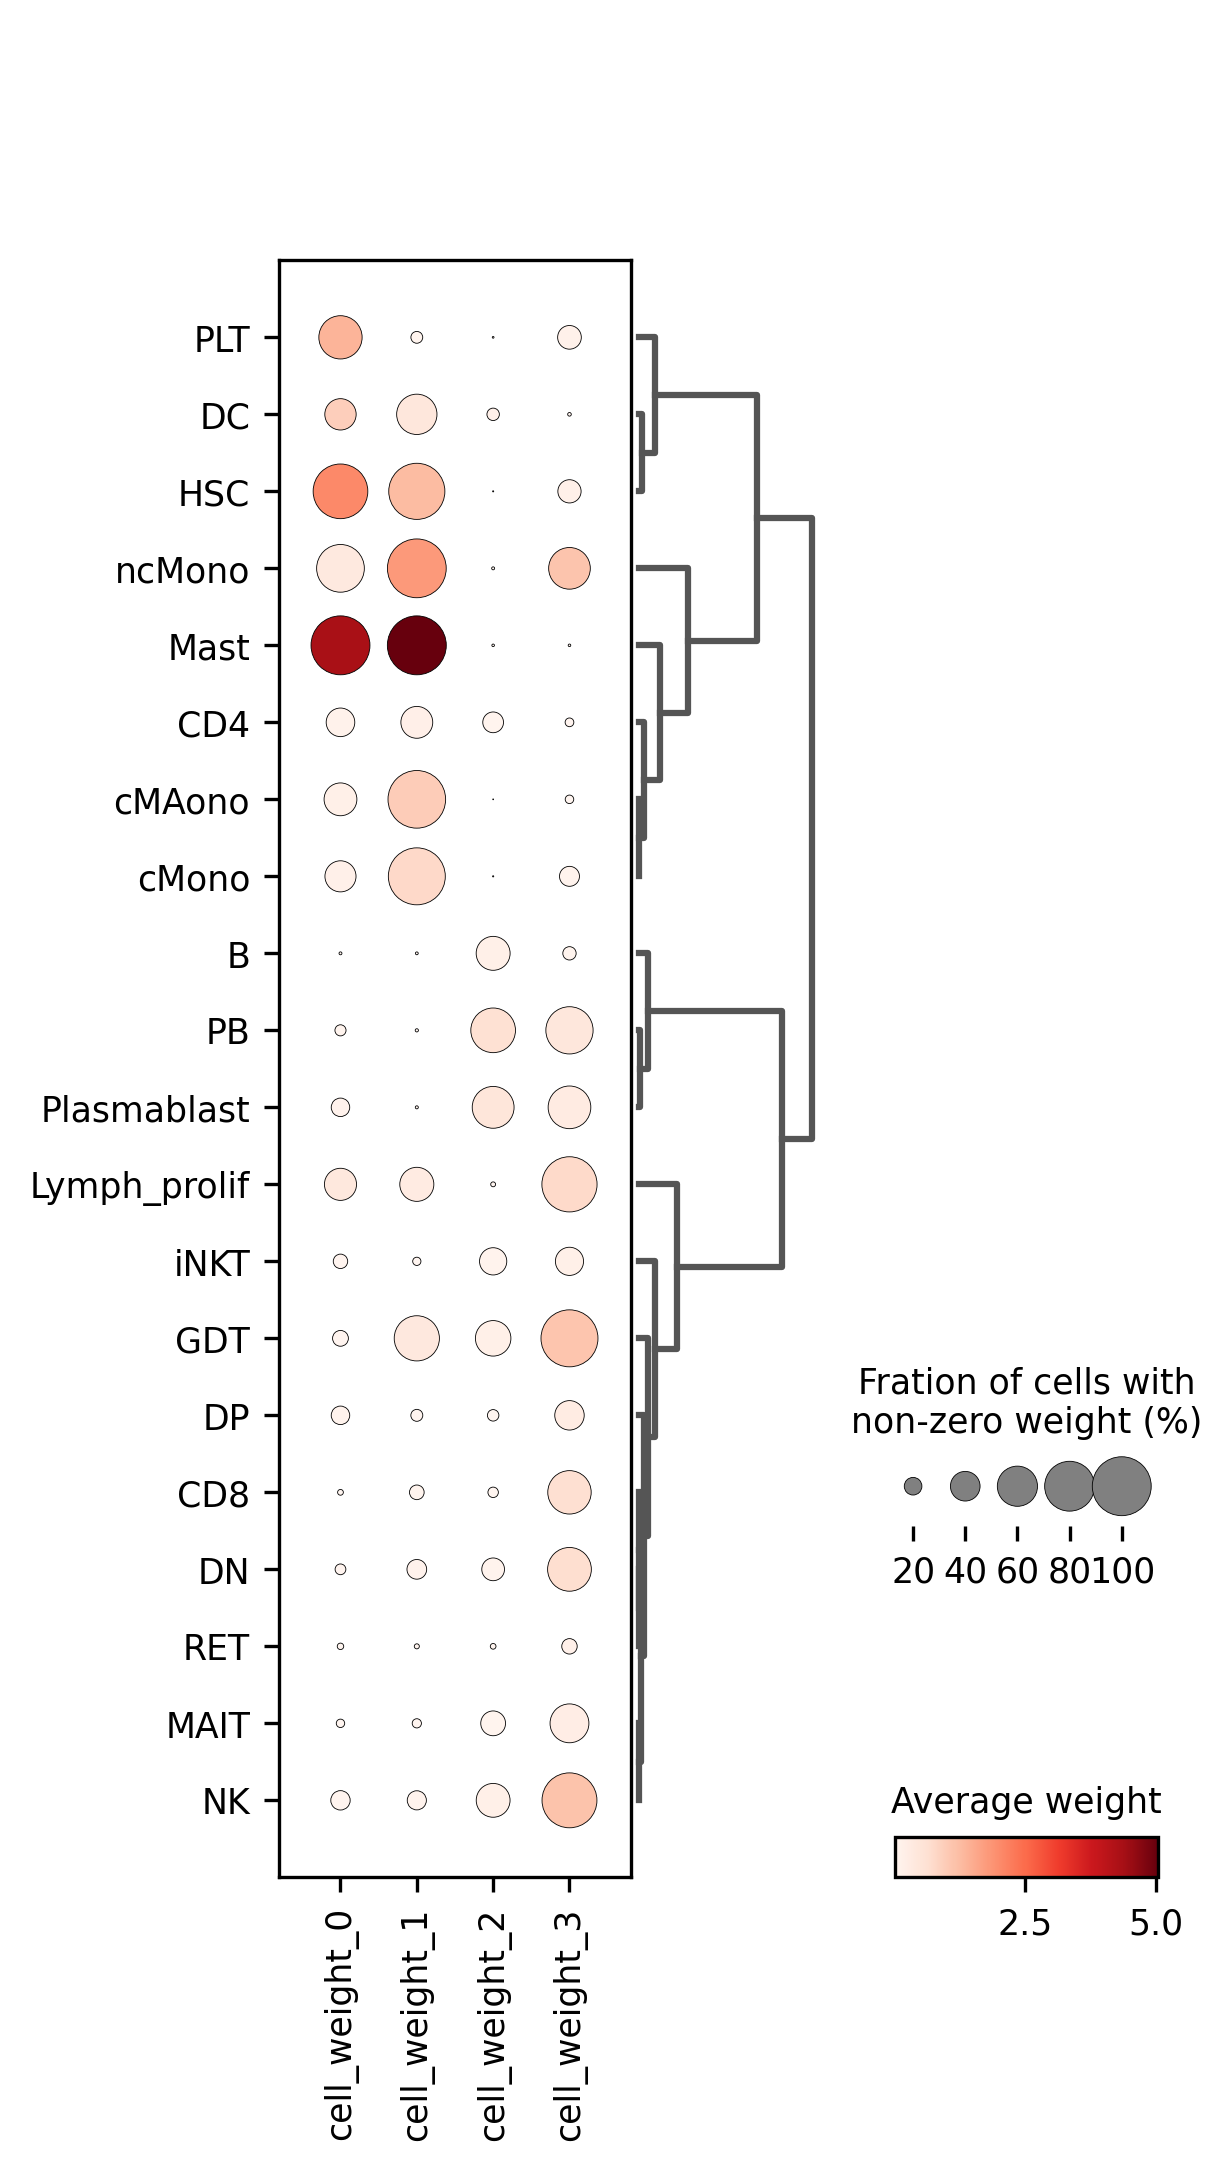

In [ ]:
sc.tl.dendrogram(adata, groupby="cell_coarse_aligned", use_rep="X_cell_weights")
with plt.rc_context({"figure.dpi": 300}):
    sc.pl.dotplot(
        adata, 
        [f"cell_weight_{i}" for i in range(cell_weights.shape[1])], 
        groupby="cell_coarse_aligned", 
        dendrogram=True,
        size_title="Fration of cells with\nnon-zero weight (%)",
        colorbar_title="Average weight",
        save="combat_stephenson_sup_batch_corrected_cell_weights.pdf"
    )


In [ ]:
cell_weights_df = pd.DataFrame(cell_weights, index=adata.obs_names, columns=[f"cell_weight_{i}" for i in range(cell_weights.shape[1])])
cell_weights_df["cell_type"] = adata.obs["cell_coarse_aligned"]
cell_weights_df


,cell_weight_0,cell_weight_1,cell_weight_2,cell_weight_3,cell_type
AAACCTGAGAAAGTGG-1-gPlexA1,0.000000,0.000000,0.0,1.632980,NK
AAACCTGAGCGGATCA-1-gPlexA1,0.000000,0.000000,0.0,1.139154,CD8
AAACCTGAGGCGACAT-1-gPlexA1,0.000000,1.231931,0.0,0.000000,ncMono
AAACCTGAGGGAACGG-1-gPlexA1,0.707345,1.549342,0.0,0.000000,cMono
AAACCTGCACATGTGT-1-gPlexA1,0.000000,0.730222,0.0,0.000000,cMono
...,...,...,...,...,...
BGCV14_TTTGTCATCGCCGTGA-1,0.000000,0.391795,0.0,0.000000,CD4
BGCV14_TTTGTCATCGCGTAGC-1,0.000000,0.000000,0.0,0.000000,cMAono
BGCV14_TTTGTCATCTAACTCT-1,0.000000,0.000000,0.0,0.000000,CD8
BGCV14_TTTGTCATCTCGCTTG-1,0.000000,0.170592,0.0,0.000000,CD4


In [ ]:
cell_weights_df.to_csv("../data/combat_stephenson_sup_batch_corrected_cell_weights.csv")

# Computing SPARE metrics

In [ ]:
import ehrapy as ep

In [ ]:
meta_adata.write("../data/combat_stephenson_combat.h5ad")

In [ ]:
meta_adata.uns["sample_representations"]

['SampleCLR_Unsupervised',
 'SampleCLR_batch_corrected',
 'SampleCLR_supervised',
 'SampleCLR_supervised_batch_corrected']

In [ ]:
# meta_adata = ep.io.read_h5ad("../data/combat_stephenson_combat.h5ad")
meta_adata

AnnData object with n_obs × n_vars = 251 × 0
    obs: 'dataset', 'Site', 'Status', 'severity_ord', 'outcome_bin', 'SARSCoV2PCR', 'TimeSinceOnset', 'split', 'Status_pred', 'severity_num', 'n_cells'
    uns: 'sample_representations'
    obsm: 'SampleCLR_Unsupervised_distances', 'SampleCLR_batch_corrected_distances', 'SampleCLR_supervised_distances', 'SampleCLR_supervised_batch_corrected_distances'
    layers: 'original'

In [ ]:
meta_adata.uns["sample_representations"] = list(meta_adata.uns["sample_representations"])

In [ ]:
# meta_adata = ep.io.df_to_anndata(metadata)
# meta_adata.uns["sample_representations"] = []
# meta_adata = ep.pp.encode(meta_adata, encodings="one-hot", autodetect=True)
# meta_adata

In [ ]:
meta_adata.obs

,dataset,Site,Status,severity_ord,outcome_bin,SARSCoV2PCR,TimeSinceOnset,split,Status_pred,severity_num,n_cells
S00109-Ja001E-PBCa,combat,Oxford,Covid,severe,0.0,1,12.0,test,Covid,3.0,3984
S00112-Ja003E-PBCa,combat,Oxford,Covid,mild,0.0,1,12.0,test,Covid,1.0,7384
S00005-Ja005E-PBCa,combat,Oxford,Covid,critical,0.0,1,14.0,test,Covid,4.0,9002
S00061-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,6.0,test,Covid,3.0,4278
S00056-Ja003E-PBCa,combat,Oxford,Covid,severe,0.0,1,23.0,test,Covid,3.0,7600
...,...,...,...,...,...,...,...,...,...,...,...
BGCV13_CV0171,stephenson,Cambridge,Covid,mild,0.0,1,15.0,train,Covid,1.0,2218
BGCV14_CV0137,stephenson,Cambridge,Covid,moderate,0.0,1,12.0,train,Covid,2.0,3875
BGCV14_CV0284,stephenson,Cambridge,Covid,NaN,NaN,1,10.0,train,Covid,NaN,3177
BGCV14_CV0940,stephenson,Cambridge,Healthy,healthy,0.0,0,NaN,train,Healthy,0.0,2958


In [ ]:
import ehrapy as ep
import numpy as np
import random
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import patpy

import pandas as pd

benchmark_schema = {
    "relevant": {
        "Status": "classification",
        "severity_num": "ranking",
        "outcome_bin": "classification",
        "TimeSinceOnset": "regression",
        
    },
    "technical": {
        "Site": "classification",
        "dataset": "classification",
        "n_cells": "regression"
    },
    "contextual": {
    }
}

trajectory_variable = "Outcome"

par = {
    "trajectory_variable": "severity_num",
    "inverse_trajectory": False,
    "root_sample": "MH8919226",  # the youngest healthy non-smoker
}

ep.settings.verbosity = "debug"

In [ ]:
meta_adata = ep.io.read_h5ad("../data/combat_stephenson_combat.h5ad")

In [ ]:
model_names = ["SampleCLR_Unsupervised", "SampleCLR_batch_corrected", "SampleCLR_supervised", "SampleCLR_supervised_batch_corrected"]

In [ ]:
for representation_name in model_names:
    print("Putting neighbors to obsp")
    ep.pp.neighbors(
        meta_adata,
        use_rep=f"{representation_name}_distances",
        key_added=f"{representation_name}_neighbors",
        metric="precomputed"
    )

Putting neighbors to obsp
Putting neighbors to obsp
Putting neighbors to obsp
Putting neighbors to obsp


In [ ]:
for representation_name in model_names:
    print("Calculating Leiden")
    ep.tl.leiden(meta_adata, key_added=f"{representation_name}_leiden", neighbors_key=f"{representation_name}_neighbors")

    print("Calculating UMAP")
    ep.tl.umap(meta_adata, neighbors_key=f"{representation_name}_neighbors")
    meta_adata.obsm[f"{representation_name}_umap"] = meta_adata.obsm["X_umap"]

print("Resulting AnnData")
print(meta_adata)

Calculating Leiden
Calculating UMAP
Calculating Leiden
Calculating UMAP
Calculating Leiden
Calculating UMAP
Calculating Leiden
Calculating UMAP
Resulting AnnData
AnnData object with n_obs × n_vars = 251 × 0
    obs: 'dataset', 'Site', 'Status', 'severity_ord', 'outcome_bin', 'SARSCoV2PCR', 'TimeSinceOnset', 'split', 'Status_pred', 'severity_num', 'n_cells', 'SampleCLR_Unsupervised_leiden', 'SampleCLR_batch_corrected_leiden', 'SampleCLR_supervised_leiden', 'SampleCLR_supervised_batch_corrected_leiden'
    uns: 'sample_representations', 'SampleCLR_Unsupervised_neighbors', 'SampleCLR_batch_corrected_neighbors', 'SampleCLR_supervised_neighbors', 'SampleCLR_supervised_batch_corrected_neighbors', 'SampleCLR_Unsupervised_leiden', 'umap', 'SampleCLR_batch_corrected_leiden', 'SampleCLR_supervised_leiden', 'SampleCLR_supervised_batch_corrected_leiden'
    obsm: 'SampleCLR_Unsupervised_distances', 'SampleCLR_batch_corrected_distances', 'SampleCLR_supervised_batch_corrected_distances', 'SampleCLR_

Computing diffmap for SampleCLR_Unsupervised
Computing diffmap for SampleCLR_batch_corrected
Computing diffmap for SampleCLR_supervised
Computing diffmap for SampleCLR_supervised_batch_corrected


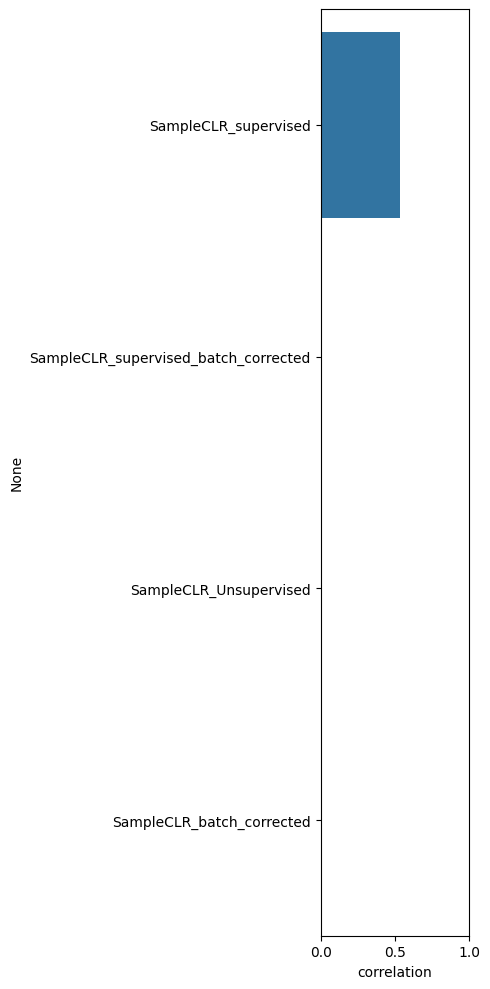

In [ ]:
random.seed(42)
np.random.seed(42)

trajectory_metric_df = patpy.tl.evaluation.trajectory_correlation(meta_adata, par["root_sample"], par["trajectory_variable"])
trajectory_metric_df.sort_values("correlation", ascending=False, inplace=True)
# trajectory_metric_df.to_csv(output_dir / "trajectory_metric.csv")

plt.figure(figsize=(5, 10))
sns.barplot(x="correlation", y=trajectory_metric_df.index, data=trajectory_metric_df, hue=trajectory_metric_df.index.str.contains("SampleCLR"), legend=False)
plt.xlim(0, 1)
plt.tight_layout()

In [ ]:
y_true = meta_adata.obs["Status"]
sepsis_samples = y_true == "Sepsis"
for representation_name in model_names:
    y_pred = patpy.tl.evaluation.predict_knn(meta_adata.obsm[f"{representation_name}_distances"], y_true=y_true, task="classification")
    
    print(f"{representation_name}: {(y_true[sepsis_samples] == y_pred[sepsis_samples]).mean()}")

SampleCLR_Unsupervised: 0.52
SampleCLR_batch_corrected: 0.4
SampleCLR_supervised: 0.52
SampleCLR_supervised_batch_corrected: 0.48


In [57]:
y_true = meta_adata.obs["Site"]
for representation_name in model_names:
    score = patpy.tl.evaluation.knn_prediction_score(meta_adata.obsm[f"{representation_name}_distances"], y_true=y_true, task="classification")
    
    print(f"{representation_name}: {(y_true == y_pred).mean()}")

TypeError: knn_prediction_score() got an unexpected keyword argument 'y_true'

In [ ]:
meta_adata.obs.loc[par["root_sample"]]

dataset                                                stephenson
Site                                                          Ncl
Status                                                    Healthy
severity_ord                                              healthy
outcome_bin                                                   0.0
SARSCoV2PCR                                                     0
TimeSinceOnset                                                NaN
split                                                         val
Status_pred                                               Healthy
severity_num                                                  0.0
n_cells                                                      1190
SampleCLR_Unsupervised_leiden                                   3
SampleCLR_batch_corrected_leiden                                6
SampleCLR_supervised_leiden                                     5
SampleCLR_supervised_batch_corrected_leiden                     6
SampleCLR_

Benchmark schema:
{'relevant': {'Status': 'classification', 'severity_num': 'ranking', 'outcome_bin': 'classification', 'TimeSinceOnset': 'regression'}, 'technical': {'Site': 'classification', 'dataset': 'classification', 'n_cells': 'regression'}, 'contextual': {}}


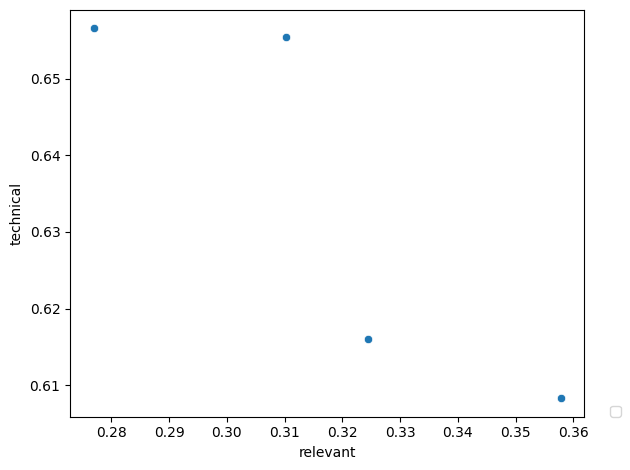

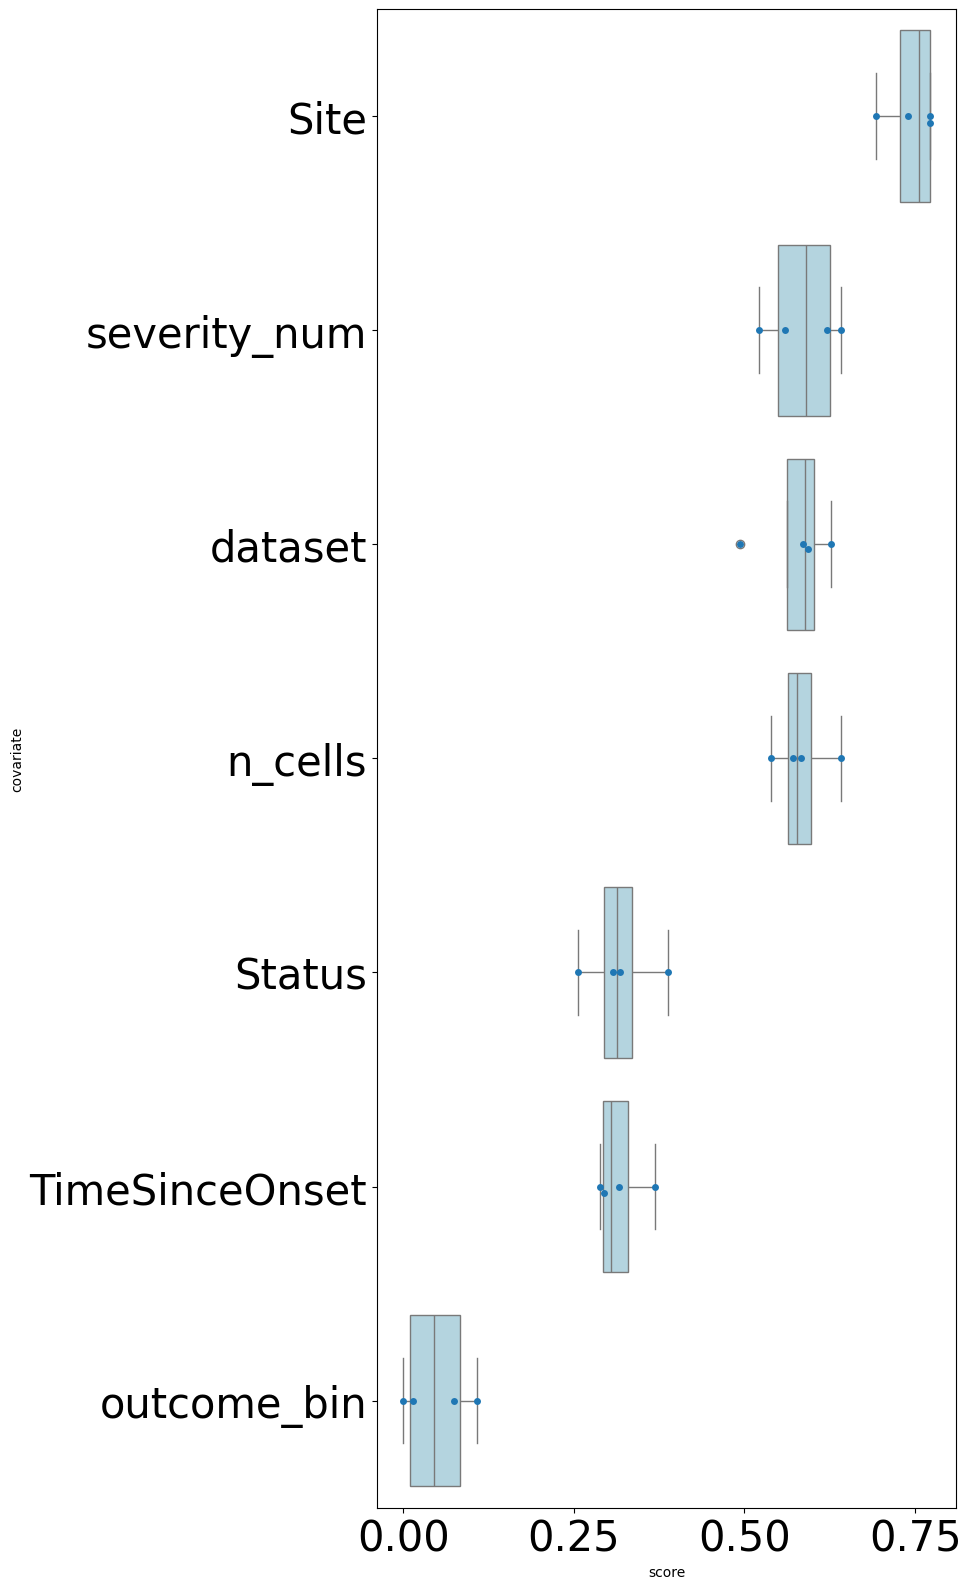

In [ ]:
print("Benchmark schema:")
print(benchmark_schema)

knn_results = patpy.tl.evaluation.knn_prediction_score(meta_adata, benchmark_schema)

avg_knn_score_df = pd.DataFrame(
    knn_results.groupby(["representation", "covariate_type"])["score"].aggregate(np.mean)
).reset_index()
avg_knn_score_df = avg_knn_score_df.sort_values("score", ascending=False)
# avg_knn_score_df.to_csv(output_dir / "avg_knn_score_df.csv")

relevant_features_weight = 2/3

averaged_scores = avg_knn_score_df.pivot(index="representation", columns="covariate_type", values="score").sort_values("relevant", ascending=False)

averaged_scores["total"] = (averaged_scores["relevant"] * relevant_features_weight + (1 - relevant_features_weight) * averaged_scores["technical"])
averaged_scores.sort_values("total", ascending=False, inplace=True)
# averaged_scores.to_csv(output_dir / "averaged_scores.csv")

sns.scatterplot(data=averaged_scores, x="relevant", y="technical")
plt.legend(loc=(1.05, 0))
plt.tight_layout()
# plt.savefig(output_dir / "tradeoff.png", format=par["figure_format"])
plt.show()
plt.close()

knn_results_wide = knn_results.pivot(index="representation", columns="covariate", values="score")
# knn_results_wide.to_csv(output_dir / "knn_results.csv")

# Order by median score
covariate_order = knn_results.groupby("covariate")["score"].median().sort_values(ascending=False).index

plt.figure(figsize=(10, 16), dpi=100)
sns.boxplot(
    knn_results[knn_results["covariate"].isin(covariate_order)],
    x="score", y="covariate", orient="h",
    order=covariate_order,
    color="lightblue"
)

plt.gca().tick_params(axis='y', labelsize=30)
plt.gca().tick_params(axis='x', labelsize=30)
sns.swarmplot(knn_results[knn_results["covariate"].isin(covariate_order)], x="score", y="covariate", orient="h", order=covariate_order)
plt.tight_layout()
# plt.savefig(output_dir / "knn_results_boxplot.png", format=par["figure_format"])
plt.show()
plt.close()

In [ ]:
trajectory_metric_df.sort_values("correlation", ascending=False)

,correlation
SampleCLR_Unsupervised,0.137755
SampleCLR_batch_corrected,-0.069158
SampleCLR_supervised,-0.419802
SampleCLR_supervised_batch_corrected,-0.447278


In [ ]:
averaged_scores.sort_values("relevant", ascending=False)

covariate_type,relevant,technical,total
representation,,,
SampleCLR_batch_corrected,0.357824,0.608307,0.441318
SampleCLR_supervised,0.324424,0.616039,0.421629
SampleCLR_supervised_batch_corrected,0.310242,0.655439,0.425308
SampleCLR_Unsupervised,0.276900,0.656542,0.403447


In [ ]:
knn_results.sort_values(["covariate", "score"], ascending=False)

,score,metric,n_unique,n_observations,method,representation,covariate,covariate_type
8,0.640955,spearman_r,5,193,knn,SampleCLR_batch_corrected,severity_num,relevant
15,0.620569,spearman_r,5,193,knn,SampleCLR_supervised,severity_num,relevant
22,0.558946,spearman_r,5,193,knn,SampleCLR_supervised_batch_corrected,severity_num,relevant
1,0.521875,spearman_r,5,193,knn,SampleCLR_Unsupervised,severity_num,relevant
9,0.108745,f1_macro_calibrated,2,229,knn,SampleCLR_batch_corrected,outcome_bin,relevant
23,0.075087,f1_macro_calibrated,2,229,knn,SampleCLR_supervised_batch_corrected,outcome_bin,relevant
2,0.013876,f1_macro_calibrated,2,229,knn,SampleCLR_Unsupervised,outcome_bin,relevant
16,0.000000,f1_macro_calibrated,2,229,knn,SampleCLR_supervised,outcome_bin,relevant
27,0.642098,spearman_r,251,251,knn,SampleCLR_supervised_batch_corrected,n_cells,technical
20,0.582153,spearman_r,251,251,knn,SampleCLR_supervised,n_cells,technical


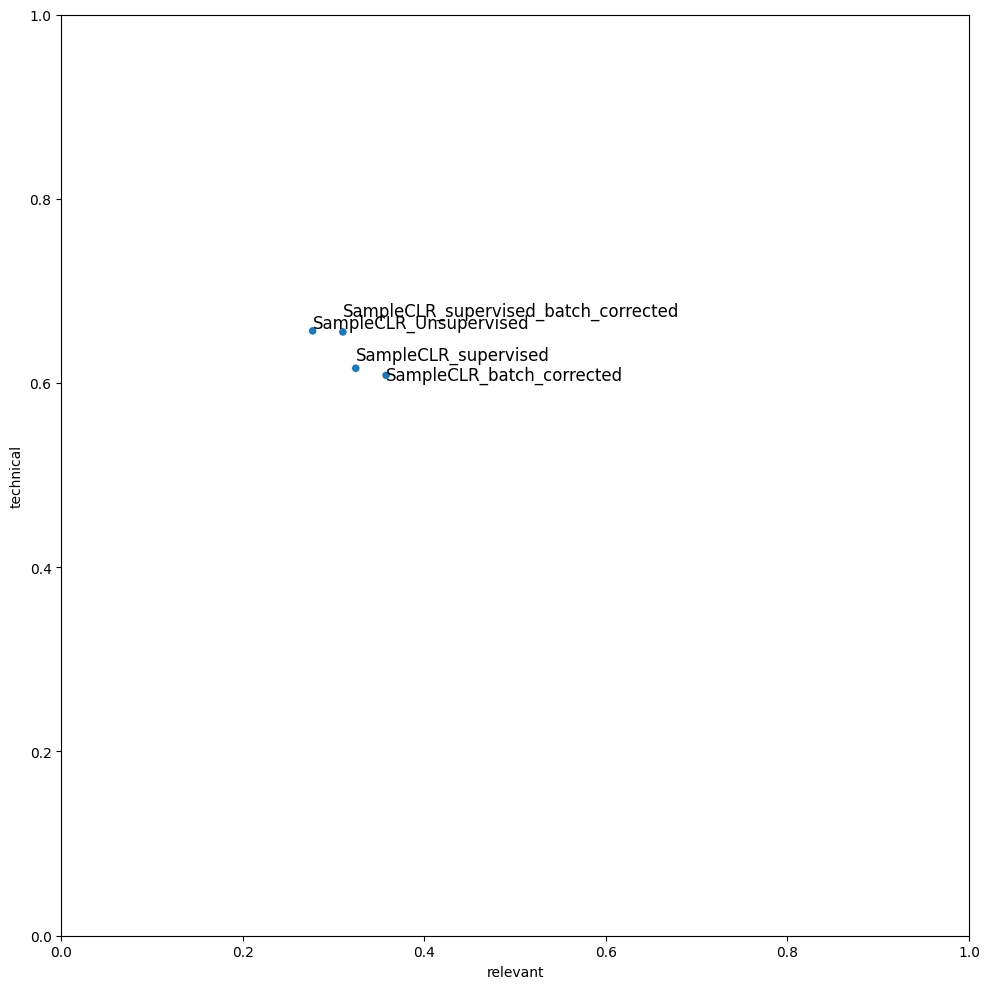

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    averaged_scores,
    x="relevant",
    y="technical",
    hue=averaged_scores.index.str.contains("SampleCLR"),
    legend=False
)

for representation, row in averaged_scores.iterrows():
    if "SampleCLR" in representation:
        plt.text(row["relevant"], row["technical"] + np.random.uniform(-0.02, 0.02), representation, fontsize=12)


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

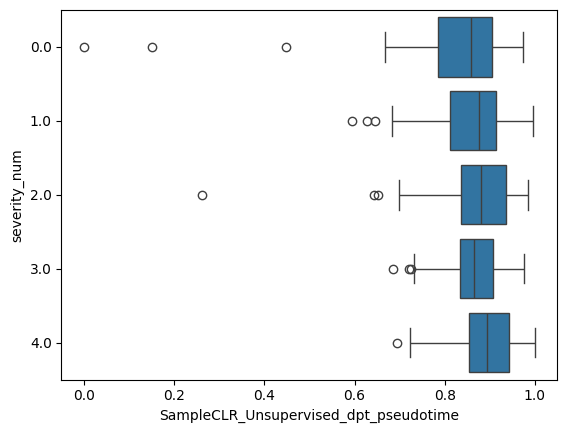

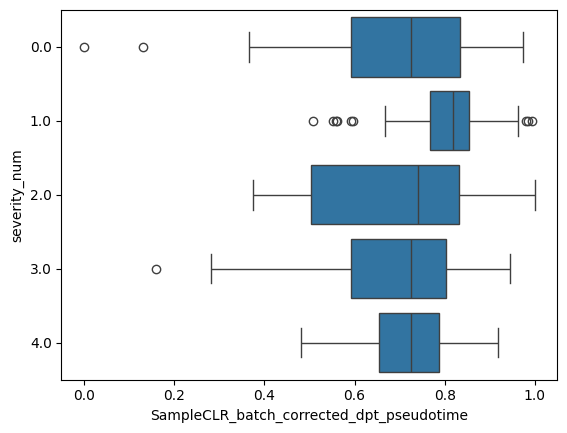

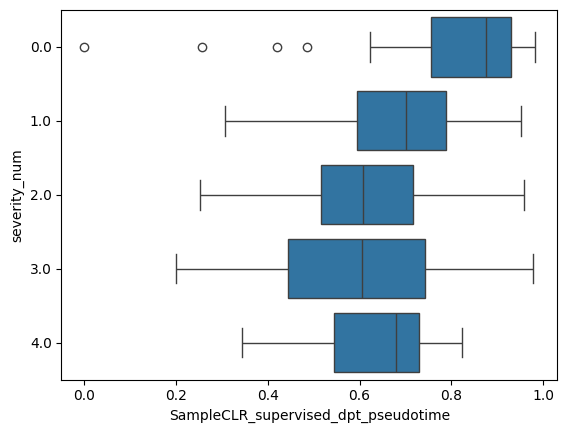

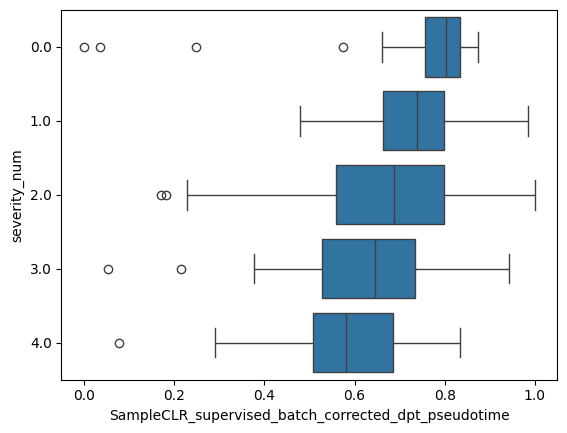

In [ ]:
for representation in model_names:
    sns.boxplot(data=meta_adata.obs, x=f"{representation}_dpt_pseudotime", y="severity_num", orient="h")
    plt.show()

In [ ]:
representation = model_names[0]

In [ ]:
ep.tl.umap(meta_adata, neighbors_key=f"{representation}_neighbors")
ep.tl.diffmap(meta_adata, neighbors_key=f"{representation}_neighbors")

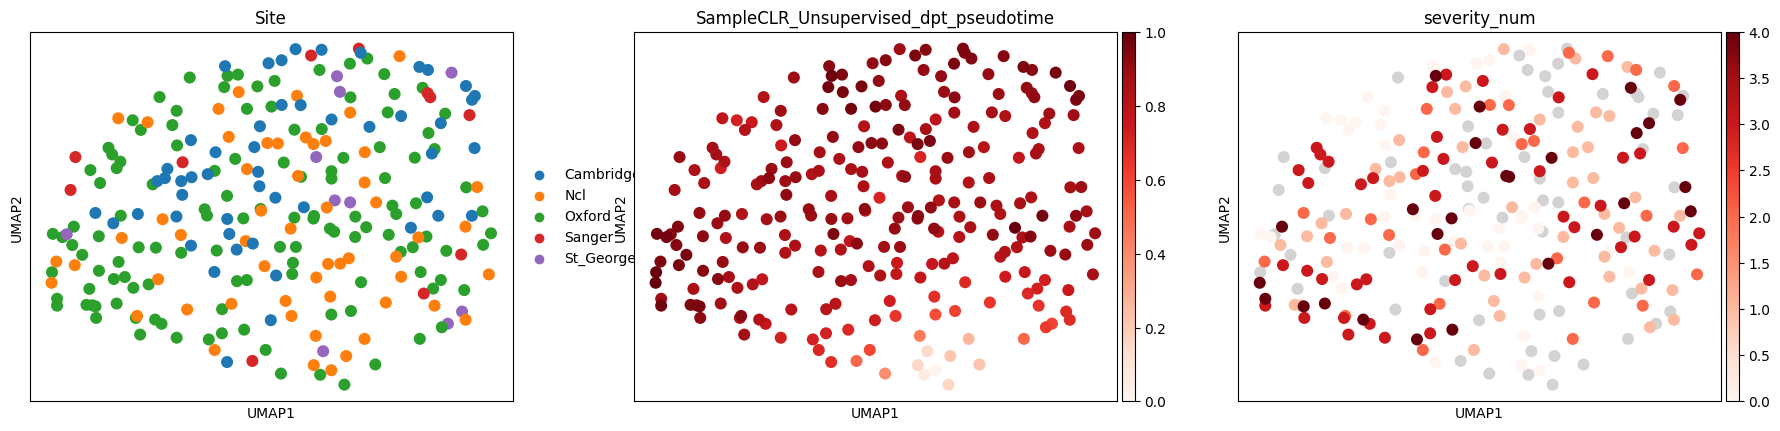

In [ ]:
ep.pl.umap(meta_adata, color=["Site", f"{representation}_dpt_pseudotime", "severity_num"], s=300, cmap="Reds")

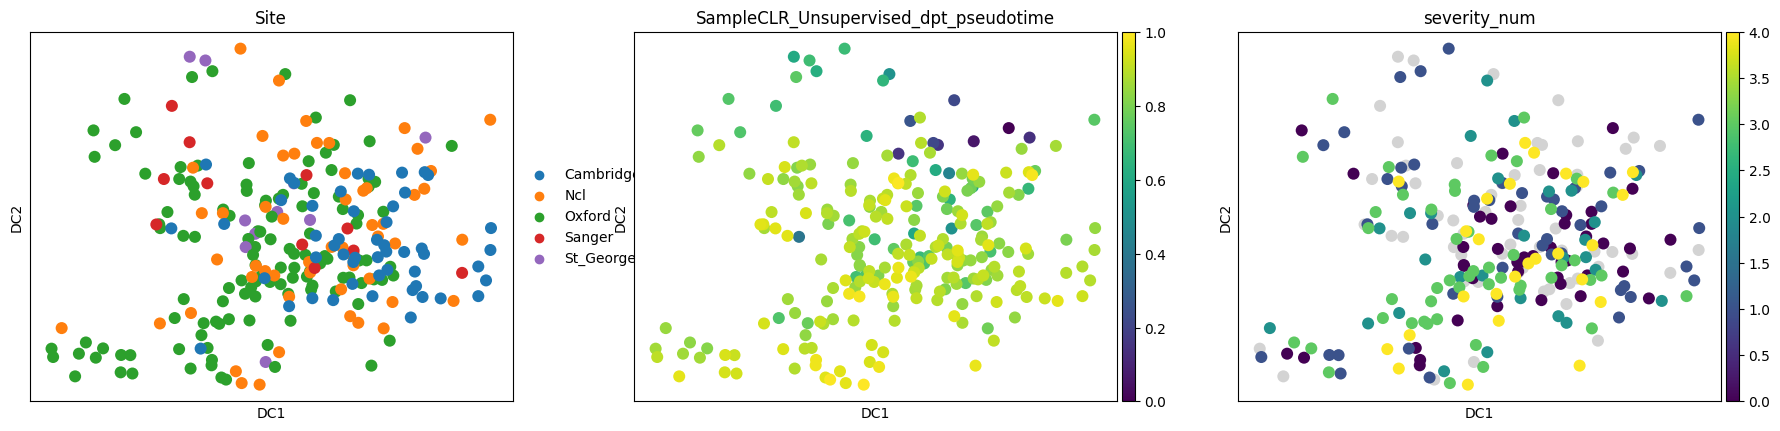

In [ ]:
ep.pl.diffmap(meta_adata, color=["Site", f"{representation}_dpt_pseudotime", "severity_num"], s=300, components="1,2")